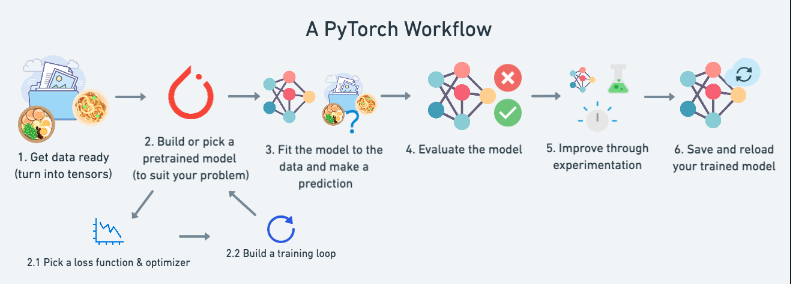

## 變數配置

In [16]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks

In [25]:
class CFG:
  SEED = 42
  weight = 0.7
  bias = 0.3

  start = 0
  end = 1
  step = 0.02

In [18]:
# 視覺化
import matplotlib.pyplot as plt

def plot_predictions(train_data, train_labels, test_data, test_labels, predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(6, 4))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

## 資料（準備和載入）

機器學習中的「數據」幾乎可以是你能想像到的任何東西。數位表（如大型 Excel 電子錶格）、任何類型的圖像、視頻（YouTube 有很多數據！）、歌曲或播客等音訊檔、蛋白質結構、文本等。

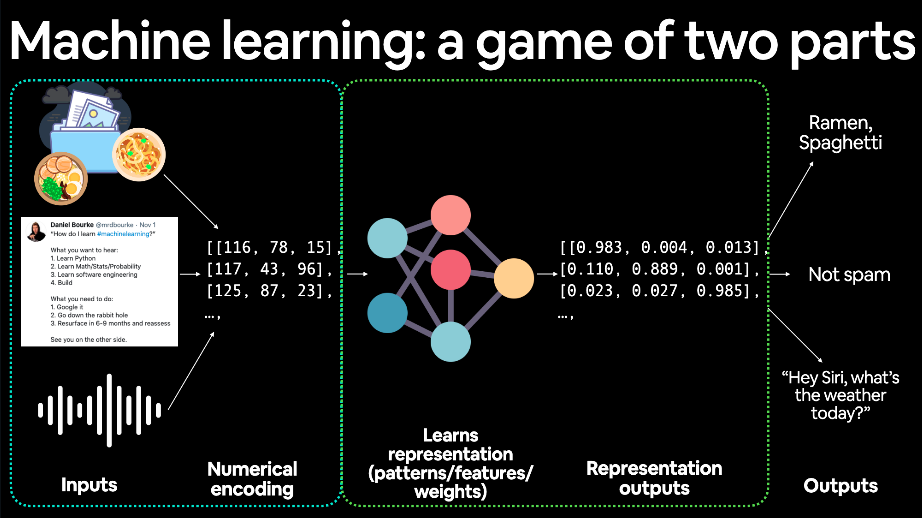

In [19]:
X = torch.arange(CFG.start, CFG.end, CFG.step).unsqueeze(dim=1)
y = CFG.weight * X + CFG.bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

## 將數據拆分為訓練集和測試集

＄ 資料集的每個分割都具有特定目的：
- Training set：抓60-80%
- Validation set：抓10-20%，非必須
- Testing set：抓10-20%

In [20]:
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

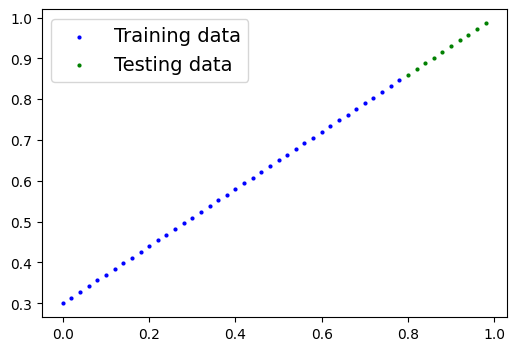

In [21]:
plot_predictions(train_data=X_train,
                train_labels=y_train,
                test_data=X_test,
                test_labels=y_test,
                predictions=None)

## 構建模型
＄ PyTorch 模組
- torch.nn：包含計算圖的所有構建塊
- torch.nn.Parameter：存儲可與一起 nn.Module 使用的張量。
- torch.nn.Module：所有神經網路模組的基類，神經網路的所有構建塊都是子類。
- torch.optim：包含各種優化演算法
- def forward()：	所有 nn.Module 子類都需要一個 forward() 方法，該方法定義了將對傳遞給特定 nn.Module 數據的數據進行的計算（例如上面的線性回歸公式）。

In [22]:
# 創建一個線性回歸模型類
class LinearRegressionModel(nn.Module):  # <- 在 PyTorch 中幾乎所有東西都是 nn.Module（將其視為神經網絡的樂高積木）
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(
            torch.randn(1,dtype=torch.float),
            requires_grad=True)  # 梯度下降

        self.bias = nn.Parameter(
            torch.randn(1, dtype=torch.float),
            requires_grad=True)  # 梯度下降

    # forward 函數定義了模型的計算過程
    def forward(self, x: torch.Tensor) -> torch.Tensor:  # <- "x" 是輸入數據（例如訓練/測試特徵）
        return self.weights * x + self.bias  # 線性回歸公式（y = m*x + b）


### @ 檢查 PyTorch 模型的內容

In [28]:
torch.manual_seed(CFG.SEED)

model_0 = LinearRegressionModel()

# 確認參數
list(model_0.parameters()) # 法一
model_0.state_dict() # 法二

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### @ 將測試數據 X_test 傳遞給模型，看看它預測的接近 y_test 程度。

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


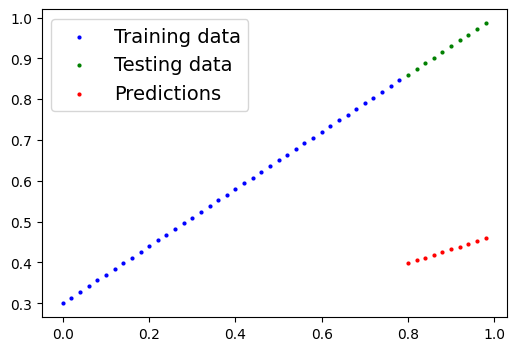

In [31]:
with torch.inference_mode():
    y_preds = model_0(X_test)

# Check the predictions
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")
plot_predictions(train_data=X_train,
                train_labels=y_train,
                test_data=X_test,
                test_labels=y_test,
                predictions=y_preds)

## 訓練模型

### @ 創建損失函數和優化器

＄ Loss function 損失函數
- 衡量模型預測（例如 y_preds ）與真值標籤（例如）的誤差程度。 y_test 越低越好。
- 回歸問題的平均絕對誤差 （MAE） torch.nn.L1Loss() （ ）。
- 二元分類問題的二元交叉熵 （ torch.nn.BCELoss() ）。

＄ Optimizer
- 告訴模型如何更新其內部參數以最好地降低損耗。
- 隨機梯度下降 （ torch.optim.SGD() ）。
- Adam 優化器 （ torch.optim.Adam() ）。

In [32]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(
    params=model_0.parameters(), # 模型參數
    lr=0.01) # 學習率

### @ 訓練回圈步驟

- Forward pass:將遍曆所有訓練數據一次，執行其 forward() 函數計算。
- 計算損失:`loss = loss_fn(y_pred, y_train)`
- 優化器梯度設置為零（預設情況下是累積的），因此可以針對特定訓練步驟重新計算梯度。`optimizer.zero_grad()`
- 對損失執行反向傳播:`loss.backward()`
- 更新優化器（梯度下降）:`optimizer.step()`

### @ 測試回圈步驟

- Forward pass:將遍曆所有訓練數據一次，執行其 forward() 函數計算。
- 計算損失:loss = loss_fn(y_pred, y_train)
- 計算評估指標

In [33]:
torch.manual_seed(CFG.SEED)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []


for epoch in range(epochs):
    ### Training
    model_0.train()
    # 輸出預設值
    y_pred = model_0(X_train)
    # 計算損失
    loss = loss_fn(y_pred, y_train)
    # 優化器梯度設置為零
    optimizer.zero_grad()
    # 反向傳播
    loss.backward()
    # 更新優化器（梯度下降）
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
      test_pred = model_0(X_test)
      # 計算損失
      test_loss = loss_fn(test_pred, y_test.type(torch.float))

      # 輸出階段情況
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135 
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519 
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819 


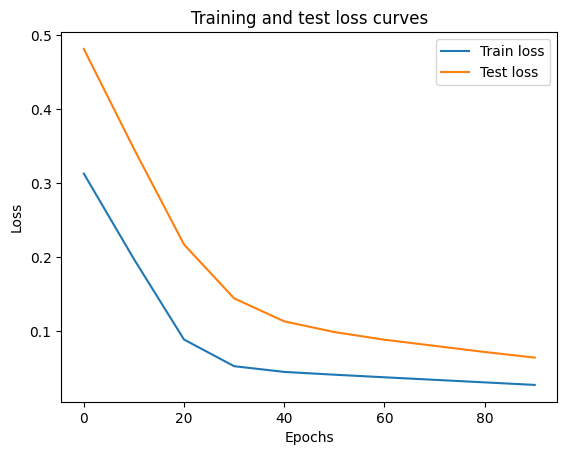

In [34]:
# 視覺化損失函數
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [35]:
# 檢查一下我們的模型 .state_dict() ，看看我們的模型與我們為權重和偏差設置的原始值有多接近。
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {CFG.weight}, bias: {CFG.bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


## 使用經過訓練的 PyTorch 模型進行預測

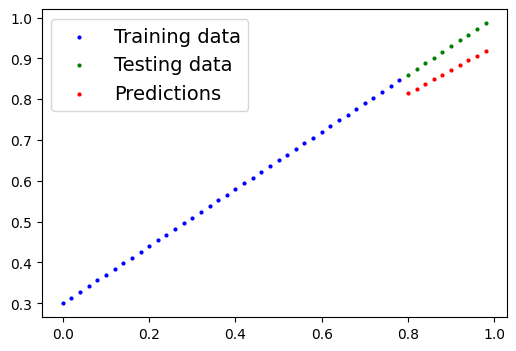

In [36]:
### test
model_0.eval()

with torch.inference_mode():
  y_preds = model_0(X_test)

plot_predictions(train_data=X_train,
                train_labels=y_train,
                test_data=X_test,
                test_labels=y_test,
                predictions=y_preds)

## 保存和載入 PyTorch 模型

### 保存 PyTorch 模型的 state_dict()

＄ 要記得，保存的東西是模型的訓練參數。

In [37]:
from pathlib import Path

# 放模型的資料夾
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
# 模型儲存路徑
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 儲存
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


### 載入保存的 PyTorch 模型的 state_dict()

In [41]:
# 初始化模型
loaded_model_0 = LinearRegressionModel()
# 載入訓練參數
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

現在，我們可以評估載入的模型，看看它的預測是否與保存之前所做的預測一致。

In [42]:
loaded_model_0.eval()

with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

# 比較
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])